In [15]:
import os
import re
import gc

from functools import partial

from concurrent.futures import ProcessPoolExecutor
import queue

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import networkx as nx

# constants
devices_root = os.path.abspath('../../')
time_field = 'geninfo/timestamp'
timedelta_field = "timedelta"

In [2]:
# read merged dataset
row_limit = None
merged_dataset_path = os.path.join(devices_root, 'idle_merged.pickle')
merged_dataset_full = pd.read_pickle(merged_dataset_path)
# only load a subset of the dataset, free up some memory
if row_limit is not None:
    merged_dataset = merged_dataset_full.iloc[:row_limit]
    del merged_dataset_full
    gc.collect()
else:
    merged_dataset = merged_dataset_full
gc.collect()
print(f"Loaded merged dataset with {len(merged_dataset)} packets")
list(sorted(merged_dataset.columns))

Loaded merged dataset with 2087024 packets


['arp/arp.hw.size',
 'arp/arp.hw.type',
 'arp/arp.opcode',
 'arp/arp.proto.size',
 'arp/arp.proto.type',
 'eth/eth.dst',
 'eth/eth.dst/eth.dst.ig',
 'eth/eth.dst/eth.dst.oui',
 'eth/eth.dst/eth.lg',
 'eth/eth.src',
 'eth/eth.src/eth.ig',
 'eth/eth.src/eth.lg',
 'eth/eth.src/eth.src.oui',
 'eth/eth.type',
 'frame/frame.encap_type',
 'frame/frame.len',
 'frame/frame.marked',
 'frame/frame.number',
 'frame/frame.offset_shift',
 'frame/frame.time_delta',
 'frame/frame.time_relative',
 'geninfo/timestamp',
 'icmp/data/data.len',
 'icmp/icmp.checksum.status',
 'icmp/icmp.code',
 'icmp/icmp.ident',
 'icmp/icmp.resp_in',
 'icmp/icmp.resp_to',
 'icmp/icmp.seq',
 'icmp/icmp.seq_le',
 'icmp/icmp.type',
 'igmp/igmp.checksum.status',
 'igmp/igmp.maddr',
 'igmp/igmp.max_resp',
 'igmp/igmp.type',
 'ip/<>/ip.options.routeralert/ip.opt.ra',
 'ip/<>/ip.options.routeralert/ip.opt.type',
 'ip/ip.checksum.status',
 'ip/ip.dsfield',
 'ip/ip.dsfield/ip.dsfield.dscp',
 'ip/ip.dsfield/ip.dsfield.ecn',
 'ip/ip.

In [3]:
merged_dataset

tcp/tcp.flags/tcp.flags.reset  arp/arp.proto.size  \
0                                False                 NaN   
1                                False                 NaN   
2                                False                 NaN   
3                                False                 NaN   
4                                False                 NaN   
...                                ...                 ...   
2087019                          False                 4.0   
2087020                          False                 4.0   
2087021                          False                 NaN   
2087022                          False                 NaN   
2087023                          False                 NaN   

         tcp/tcp.options/tcp.options.nop  tcp/tcp.checksum.status  \
0                                    1.0                      2.0   
1                                    1.0                      2.0   
2                                    NaN                      2.0   
3                                    NaN                      2.0   
4                                    NaN                      2.0   
...                                  ...                      ...   
2087019                              NaN                      NaN   
2087020                              NaN                      NaN   
2087021                              NaN                      2.0   
2087022                              NaN                      2.0   
2087023                              NaN                      2.0   

         udp/udp.checksum.status  tcp/tcp.nxtseq  \
0                            NaN             1.0   
1                            NaN             1.0   
2                            NaN            70.0   
3                            NaN            70.0   
4                            NaN            70.0   
...                          ...             ...   
2087019                      NaN             NaN   
2087020                      NaN             NaN   
2087021                      NaN        136346.0   
2087022                      NaN        133465.0   
2087023                      NaN        136346.0   

         tcp/tcp.options/tcp.options.mss/tcp.options.mss_val  tcp/tcp.hdr_len  \
0                                                      NaN               32.0   
1                                                      NaN               32.0   
2                                                      NaN               20.0   
3                                                      NaN               20.0   
4                                                      NaN               20.0   
...                                                    ...                ...   
2087019                                                NaN                NaN   
2087020                                                NaN                NaN   
2087021                                                NaN               20.0   
2087022                                                NaN               20.0   
2087023                                                NaN               20.0   

         tcp/tcp.stream       ip/ip.dst  ...  arp/arp.hw.type  \
0                   0.0   192.168.1.201  ...              NaN   
1                   0.0   54.155.16.139  ...              NaN   
2                   1.0  76.223.105.139  ...              NaN   
3                   1.0   192.168.1.178  ...              NaN   
4                   1.0  76.223.105.139  ...              NaN   
...                 ...             ...  ...              ...   
2087019             NaN             NaN  ...              1.0   
2087020             NaN             NaN  ...              1.0   
2087021             6.0  13.248.240.249  ...              NaN   
2087022             6.0   192.168.1.179  ...              NaN   
2087023             6.0  13.248.240.249  ...              NaN   

               eth/eth.src  frame/frame.time_relative tc

In [4]:
def extract_to_graph(input_graph: nx.Graph,
                     packet: dict | pd.Series,
                     source_field: str,
                     destination_field: str,
                     per_packet_fields: list[str],
                     per_second_fields: list[str],
                     timedelta_field: str):
    """
    Extract the given fields from the packet and add them to the graph
    :param input_graph: graph to update
    :param packet: packet to analyze
    :param source_field: source field
    :param destination_field: destination field
    :param per_packet_fields: fields to extract per packet
    :param per_second_fields: fields to extract per second
    :param timedelta_field: field containing the timedelta to the start of the capture
    :return: updated graph
    """
    # get timedelta to start of capture
    timedelta = packet[timedelta_field]

    # get current second
    try:
        second = int(timedelta.total_seconds())
    except ValueError:
        # unusable packet
        return input_graph

    # get src and destination address
    src = packet[source_field]
    dst = packet[destination_field]

    if pd.isna(src) or pd.isna(dst):
        # unusable packet
        return input_graph

    # add nodes, if not already present
    if not input_graph.has_node(src):
        input_graph.add_node(src)
    if not input_graph.has_node(dst):
        input_graph.add_node(dst)

    # check content of packet to determine layer
    if packet["tcp/tcp.srcport"] is not np.nan:
        min_layer = 4
    elif packet["ip/ip.src"] is not np.nan:
        min_layer = 3
    elif packet["eth/eth.src"] is not np.nan:
        min_layer = 2
    else:
        min_layer = 1

    # add edge, if not already present
    if not input_graph.has_edge(src, dst):
        input_graph.add_edge(src, dst)

        # add per packet fields
        for field in per_packet_fields:
            if field["min_layer"] <= min_layer:
                input_graph[src][dst][field["name"]] = field["base_value_function"](packet)

        # add per second fields
        for field in per_second_fields:
            if field["min_layer"] <= min_layer:
                input_graph[src][dst][field["name"]] = {second: field["base_value_function"](packet)}

    else:

        # update per packet fields
        for field in per_packet_fields:
            if field["min_layer"] <= min_layer:
                input_graph[src][dst][field["name"]] = (
                    field["update_function"](input_graph[src][dst][field["name"]], packet))

        # update per second fields
        for field in per_second_fields:
            if second not in input_graph[src][dst][field["name"]]:
                if field["min_layer"] <= min_layer:
                    input_graph[src][dst][field["name"]][second] = field["base_value_function"](packet)
            else:
                if field["min_layer"] <= min_layer:
                    input_graph[src][dst][field["name"]][second] = \
                        field["update_function"](input_graph[src][dst][field["name"]][second], packet)

    return input_graph

In [19]:

def update_layer_3_graph(packet: pd.Series,
                         state: dict,
                         packet_index: int,
                         per_packet_fields: list,
                         per_second_fields: list,
                         timedelta_field: str) -> dict:
    """
    Update the layer 3 graph
    :param packet: packet to analyze
    :param state: current state of the model
    :param packet_index: index of the packet
    :param per_packet_fields: fields to extract per packet
    :param per_second_fields: fields to extract per second
    :param timedelta_field: field containing the timedelta to the start of the capture
    :return: updated state
    """
    layer_3_graph = state["layer_3_graph"] if "layer_3_graph" in state else nx.DiGraph()

    layer_3_graph = extract_to_graph(layer_3_graph, packet,
                                     "ip/ip.src",
                                     "ip/ip.dst",
                                     per_packet_fields,
                                     per_second_fields,
                                     timedelta_field)

    state["layer_3_graph"] = layer_3_graph
    return state


def update_layer_2_graph(packet: pd.Series,
                         state: dict,
                         packet_index: int,
                         per_packet_fields: list,
                         per_second_fields: list,
                         timedelta_field: str) -> dict:
    """
    Update the layer 2 graph
    :param packet: packet to analyze
    :param state: current state of the model
    :param packet_index: index of the packet
    :param per_packet_fields: fields to extract per packet
    :param per_second_fields: fields to extract per second
    :param timedelta_field: field containing the timedelta to the start of the capture
    :return: updated state
    """
    layer_2_graph = state["layer_2_graph"] if "layer_2_graph" in state else nx.DiGraph()

    layer_2_graph = extract_to_graph(layer_2_graph, packet,
                                     "eth/eth.src",
                                     "eth/eth.dst",
                                     per_packet_fields,
                                     per_second_fields,
                                     timedelta_field)

    state["layer_2_graph"] = layer_2_graph
    return state


# extract_ip_hosts(merged_dataset.iloc[2], {})
def process_packet(packet: dict | pd.Series,
                   state: dict,
                   packet_index: int,
                   processing_functions: list[callable]) -> dict:
    """
    Digest a packet and update the state 
    :param packet: packet to digest
    :param state: state of the model
    :param packet_index: index of the packet
    :param processing_functions: functions to apply to the packet
    :return: updated state
    """

    for processing_function in processing_functions:
        state = processing_function(packet, state, packet_index)

    return state

In [13]:
def update_port_list(packet: dict | pd.Series, current_port_list: list, port_field: str) -> list:
    if pd.isna(packet[port_field]):
        return current_port_list
    else:
        port = int(packet[port_field])
        if port not in current_port_list:
            current_port_list.append(port)
        return current_port_list


In [24]:


per_packet_fields = [
    {
        "name": "total_packet_count",
        "min_layer": 2,
        "base_value_function": lambda _: 1,
        "update_function": lambda x, _: x + 1
    },
    {
        "name": "total_bytes",
        "min_layer": 2,
        "base_value_function": lambda packet: packet["frame/frame.len"],
        "update_function": lambda x, packet: x + packet["frame/frame.len"]
    },
    {
        "name": "src_ports",
        "min_layer": 4,
        "base_value_function": lambda packet: update_port_list(packet, [], "tcp/tcp.srcport"),
        "update_function": lambda x, packet: update_port_list(packet, x, "tcp/tcp.srcport"),
    },
    {
        "name": "dst_ports",
        "min_layer": 4,
        "base_value_function": lambda packet: update_port_list(packet, [], "tcp/tcp.dstport"),
        "update_function": lambda x, packet: update_port_list(packet, x, "tcp/tcp.dstport"),
    },
]

per_second_fields = [
    {
        "name": "packets_per_second",
        "min_layer": 2,
        "base_value_function": lambda _: 1,
        "update_function": lambda x, _: x + 1
    },
    {
        "name": "bytes_per_second",
        "min_layer": 2,
        "base_value_function": lambda packet: packet["frame/frame.len"],
        "update_function": lambda x, packet: x + packet["frame/frame.len"]
    }
]

processing_functions = [
    partial(update_layer_3_graph, per_packet_fields=per_packet_fields, per_second_fields=per_second_fields,
            timedelta_field=timedelta_field),
    partial(update_layer_2_graph, per_packet_fields=per_packet_fields, per_second_fields=per_second_fields,
            timedelta_field=timedelta_field)
]

state = {}
for index, packet in tqdm(merged_dataset.iloc[:100_000].iterrows()):
    state = process_packet(packet, state, index, processing_functions)
# for index, packet in tqdm(merged_dataset.iterrows()):
#     state = process_packet(packet, state, processing_functions)

layer_2_graph = state["layer_2_graph"]
layer_3_graph = state["layer_3_graph"]

100000it [00:09, 10267.98it/s]


In [25]:
layer_3_graph.edges(data=True)

OutEdgeDataView([('54.155.16.139', '192.168.1.201', {'total_packet_count': 2435, 'total_bytes': 245300, 'src_ports': [443], 'dst_ports': [49872], 'packets_per_second': {0: 1, 2: 2, 20: 1, 33: 1, 40: 1, 61: 1, 64: 1, 81: 1, 95: 1, 102: 1, 122: 1, 127: 1, 143: 1, 158: 1, 163: 1, 184: 1, 189: 1, 204: 1, 220: 1, 225: 1, 244: 1, 245: 1, 266: 1, 275: 1, 286: 1, 306: 1, 307: 1, 327: 1, 337: 1, 348: 1, 368: 1, 369: 2, 370: 1, 371: 2, 391: 1, 403: 1, 411: 1, 432: 1, 434: 1, 452: 1, 465: 1, 473: 1, 485: 1, 493: 1, 514: 1, 516: 1, 534: 1, 547: 1, 555: 1, 575: 1, 578: 1, 595: 1, 609: 1, 616: 1, 636: 1, 640: 1, 657: 1, 671: 1, 677: 1, 698: 1, 703: 1, 718: 1, 727: 1, 739: 1, 758: 1, 759: 1, 780: 1, 789: 1, 800: 1, 820: 1, 821: 1, 831: 3, 841: 1, 862: 1, 863: 2, 876: 1, 882: 1, 902: 2, 903: 1, 923: 1, 933: 1, 944: 1, 964: 1, 965: 1, 968: 1, 987: 1, 999: 1, 1007: 1, 1028: 1, 1030: 1, 1048: 1, 1061: 1, 1069: 1, 1089: 1, 1091: 3, 1092: 1, 1093: 1, 1110: 1, 1124: 1, 1130: 1, 1150: 1, 1155: 1, 1171: 1, 11

In [28]:
def get_info_for_node(graph: nx.Graph, node: str):
    """
    Get info for a node
    :param graph: graph to analyze
    :param node: node to analyze
    :return: info for the node
    """
    edges = list(graph.edges(node, data=True))
    return edges


nodes = list(layer_2_graph.nodes)

node_info = get_info_for_node(layer_2_graph, nodes[0])
src, dest, data = node_info[2]

print(f"Connection between {src} and {dest}")
data.keys()

Connection between 54:83:3a:70:be:a6 and 70:ee:50:90:64:04


dict_keys(['total_packet_count', 'total_bytes', 'src_ports', 'dst_ports', 'packets_per_second', 'bytes_per_second'])

In [31]:
def extract_connections(graph: nx.Graph) -> list:
    """
    Extract connections from a graph
    :param graph: graph to analyze
    :return: list of connections
    """
    connections = []
    for src, dest, data in graph.edges(data=True):
        connections.append((src, dest, data))
    return connections


connections = extract_connections(layer_2_graph)
print(f"Found {len(connections)} connections")
src, dest, data = connections[11]
data

Found 97 connections


{'total_packet_count': 315,
 'total_bytes': 24419,
 'src_ports': [443],
 'dst_ports': [52433],
 'packets_per_second': {128: 1,
  133: 1,
  328: 1,
  333: 1,
  528: 2,
  533: 1,
  728: 2,
  733: 1,
  928: 1,
  933: 1,
  1128: 1,
  1133: 1,
  1157: 2,
  1162: 1,
  1328: 1,
  1333: 1,
  1528: 1,
  1533: 1,
  1728: 1,
  1733: 1,
  1928: 1,
  1933: 1,
  2128: 1,
  2133: 1,
  2328: 1,
  2334: 1,
  2528: 1,
  2534: 1,
  2729: 1,
  2734: 1,
  2929: 1,
  2934: 1,
  2962: 2,
  3129: 1,
  3134: 1,
  3329: 1,
  3334: 1,
  3529: 1,
  3534: 1,
  3729: 1,
  3734: 1,
  3929: 1,
  3934: 1,
  4129: 1,
  4134: 1,
  4329: 1,
  4334: 1,
  4529: 1,
  4534: 1,
  4729: 1,
  4734: 1,
  4767: 2,
  4929: 2,
  4934: 1,
  5129: 2,
  5134: 1,
  5329: 1,
  5334: 1,
  5529: 1,
  5534: 1,
  5729: 1,
  5734: 1,
  5929: 1,
  5934: 1,
  6129: 1,
  6134: 1,
  6329: 1,
  6334: 1,
  6529: 1,
  6534: 1,
  6572: 2,
  6729: 1,
  6734: 1,
  6929: 1,
  6935: 1,
  7130: 1,
  7135: 1,
  7330: 1,
  7335: 1,
  7530: 1,
  7535: 1,
  

In [ ]:
features = ["total_packet_count",
            "time_delta_to_last_packet",
            "total_bytes",
            "packets_per_second",
            "bytes_per_second",
            "connections_to",
            "connections_from",
            "num_src_ports",
            "num_dst_ports"]

In [75]:
def create_dataset_for_node(node, edges, first_second: int = None, last_second: int = None) -> pd.DataFrame:
    """
    Create a dataset for a connection
    :param node: name of the node
    :param edges: edges going out and coming into the node
    :param first_second: first second to include in the dataset
    :param last_second: last second to include in the dataset
    :return: dataset for the connection
    """

    outgoing = [edge for edge in edges if edge[0] == node]
    incoming = [edge for edge in edges if edge[1] == node]

    out_packet_seconds = list()
    for edge in outgoing:
        out_packet_seconds += list(edge[2]["packets_per_second"].keys())

    in_packet_seconds = list()
    for edge in incoming:
        in_packet_seconds += list(edge[2]["packets_per_second"].keys())

    # filter out seconds, if first_second or last_second is given
    if first_second is not None or last_second is not None:
        if first_second is None:
            first_second = min(out_packet_seconds + in_packet_seconds)
        if last_second is None:
            last_second = max(out_packet_seconds + in_packet_seconds)

        in_packet_seconds = [second for second in in_packet_seconds if first_second <= second <= last_second]
        out_packet_seconds = [second for second in out_packet_seconds if first_second <= second <= last_second]

    # get incoming packets per second for each second
    incoming_packets = list()
    incoming_bytes = list()
    for second in in_packet_seconds:
        incoming_packets_this_second = 0
        incoming_bytes_this_second = 0
        for src, dest, data in incoming:
            # get packets per second
            pps = data["packets_per_second"]
            if second in pps:
                incoming_packets_this_second += int(pps[second])
            bps = data["bytes_per_second"]
            if second in bps:
                incoming_bytes_this_second += int(bps[second])

        if len(incoming_packets) == 0:
            incoming_packets.append(int(incoming_packets_this_second))
        else:
            incoming_packets.append(int(incoming_packets_this_second) + incoming_packets[-1])

        if len(incoming_bytes) == 0:
            incoming_bytes.append(int(incoming_bytes_this_second))
        else:
            incoming_bytes.append(int(incoming_bytes_this_second) + incoming_bytes[-1])

    outgoing_packets = list()
    outgoing_bytes = list()
    for second in out_packet_seconds:
        outgoing_packets_this_second = 0
        outgoing_bytes_this_second = 0
        for src, dest, data in outgoing:
            # get packets per second
            pps = data["packets_per_second"]
            if second in pps:
                outgoing_packets_this_second += int(pps[second])
            bps = data["bytes_per_second"]
            if second in bps:
                outgoing_bytes_this_second += int(bps[second])

        if len(outgoing_packets) == 0:
            outgoing_packets.append(int(outgoing_packets_this_second))
        else:
            outgoing_packets.append(int(outgoing_packets_this_second) + outgoing_packets[-1])
        if len(outgoing_bytes) == 0:
            outgoing_bytes.append(int(outgoing_bytes_this_second))
        else:
            outgoing_bytes.append(int(outgoing_bytes_this_second) + outgoing_bytes[-1])

    # get time diff to last outgoing packet
    diff_to_last_outgoing = [0] + [out_packet_seconds[i] - out_packet_seconds[i - 1] for i in
                                   range(1, len(out_packet_seconds))]
    # get time diff to last incoming packet
    diff_to_last_incoming = [0] + [in_packet_seconds[i] - in_packet_seconds[i - 1] for i in
                                   range(1, len(in_packet_seconds))]

    # get the second where each incoming connection was first seen by extracting it from the first packet second
    incoming_first_seen = list()
    for src, dest, data in incoming:
        incoming_first_seen.append(list(data["packets_per_second"].keys())[0])

    # get the total number of incoming connection made per second
    total_incoming_per_second = list()
    for second in in_packet_seconds:
        # count the number of items smaller than the current second in the incoming first seen list
        total_incoming_per_second.append(sum([1 for first_seen in incoming_first_seen if first_seen <= second]))

    # get the second where each outgoing connection was first seen by extracting it from the first packet second
    outgoing_first_seen = list()
    for src, dest, data in outgoing:
        outgoing_first_seen.append(list(data["packets_per_second"].keys())[0])

    # get the total number of outgoing connection made per second
    total_outgoing_per_second = list()
    for second in out_packet_seconds:
        # count the number of items smaller than the current second in the outgoing first seen list
        total_outgoing_per_second.append(sum([1 for first_seen in outgoing_first_seen if first_seen <= second]))

    # get total incoming ports
    incoming_ports = list()
    for src, dest, data in incoming:
        incoming_ports = [port for port in data["src_ports"] if port not in incoming_ports]

    # get total outgoing ports
    outgoing_ports = list()
    for src, dest, data in outgoing:
        outgoing_ports = [port for port in data["dst_ports"] if port not in outgoing_ports]

    incoming_data = {
        "incoming_packets": incoming_packets,
        "incoming_bytes": incoming_bytes,
        "diff_to_last_incoming": diff_to_last_incoming,
        "total_incoming_per_second": total_incoming_per_second,
        "incoming_ports": [len(incoming_ports)] * len(in_packet_seconds),
    }
    # set index to the packet seconds
    df_incoming = pd.DataFrame(incoming_data, index=in_packet_seconds)

    outgoing_data = {
        "outgoing_packets": outgoing_packets,
        "outgoing_bytes": outgoing_bytes,
        "diff_to_last_outgoing": diff_to_last_outgoing,
        "total_outgoing_per_second": total_outgoing_per_second,
        "outgoing_ports": [len(outgoing_ports)] * len(out_packet_seconds),
    }
    # set index to the packet seconds
    df_outgoing = pd.DataFrame(outgoing_data, index=out_packet_seconds)

    # merge incoming and outgoing data on packet seconds
    data = pd.merge(df_incoming, df_outgoing, how="outer", left_index=True, right_index=True)

    # fill missing values with last set value (forward fill)
    data = data.ffill()

    # parse all columns as int
    data = data.astype(int)
    return data


nodes = list(layer_3_graph.nodes)
node = nodes[3]
# get all edges connected to the node
edges = list(layer_3_graph.in_edges(node, data=True)) + list(layer_3_graph.out_edges(node, data=True))

create_dataset_for_node(node, edges, first_second=3, last_second=5)

Empty DataFrame
Columns: [incoming_packets, incoming_bytes, diff_to_last_incoming, total_incoming_per_second, incoming_ports, outgoing_packets, outgoing_bytes, diff_to_last_outgoing, total_outgoing_per_second, outgoing_ports]
Index: []

In [10]:
def get_packets_for_connection(connection: tuple[str, str, dict], packets: pd.DataFrame) -> list:
    """
    Get packets for a connection.
    :param connection: connection triple, with src, dest and data
    :param packets: dataframe containing all the packets
    :return: dataframe containing only the packets for the given connection
    """

    src, dest, data = connection
    is_mac = re.compile(r"([0-9a-f]{2}[:-]){5}([0-9a-f]{2})")
    is_ip = re.compile(r"([0-9]{1,3}\.){3}([0-9]{1,3})")
    if is_mac.match(src):
        packets_for_connection = packets[(packets["eth/eth.src"] == src) & (packets["eth/eth.dst"] == dest)]
    elif is_ip.match(src):
        packets_for_connection = packets[(packets["ip/ip.src"] == src) & (packets["ip/ip.dst"] == dest)]
    else:
        raise ValueError(f"Unknown source {src}")

    if len(packets_for_connection) == 0:
        raise ValueError(f"No packets found for connection {connection}")
    return packets_for_connection


packets_for_connection = get_packets_for_connection(connections[10], merged_dataset)
packets_for_connection

tcp/tcp.flags/tcp.flags.reset  arp/arp.proto.size  \
415                            False                 NaN   
433                            False                 4.0   
1110                           False                 NaN   
1131                           False                 4.0   
1746                           False                 NaN   
...                              ...                 ...   
98186                          False                 NaN   
98876                          False                 NaN   
98888                          False                 4.0   
99606                          False                 NaN   
99623                          False                 4.0   

       tcp/tcp.options/tcp.options.nop  tcp/tcp.checksum.status  \
415                                NaN                      2.0   
433                                NaN                      NaN   
1110                               NaN                      2.0   
1131                               NaN                      NaN   
1746                               NaN                      2.0   
...                                ...                      ...   
98186                              NaN                      NaN   
98876                              NaN                      2.0   
98888                              NaN                      NaN   
99606                              NaN                      2.0   
99623                              NaN                      NaN   

       udp/udp.checksum.status  tcp/tcp.nxtseq  \
415                        NaN            54.0   
433                        NaN             NaN   
1110                       NaN           107.0   
1131                       NaN             NaN   
1746                       NaN           160.0   
...                        ...             ...   
98186                      2.0             NaN   
98876                      NaN          6944.0   
98888                      NaN             NaN   
99606                      NaN          6997.0   
99623                      NaN             NaN   

       tcp/tcp.options/tcp.options.mss/tcp.options.mss_val  tcp/tcp.hdr_len  \
415                                                  NaN               20.0   
433                                                  NaN                NaN   
1110                                                 NaN               20.0   
1131                                                 NaN                NaN   
1746                                                 NaN               20.0   
...                                                  ...                ...   
98186                                                NaN                NaN   
98876                                                NaN               20.0   
98888                                                NaN                NaN   
99606                                                NaN               20.0   
99623                                                NaN                NaN   

       tcp/tcp.stream      ip/ip.dst  ...  arp/arp.hw.type        eth/eth.src  \
415              11.0  192.168.1.179  ...              NaN  54:83:3a:70:be:a6   
433               NaN            NaN  ...              1.0  54:83:3a:70:be:a6   
1110             11.0  192.168.1.179  ...              NaN  54:83:3a:70:be:a6   
1131              NaN            NaN  ...              1.0  54:83:3a:70:be:a6   
1746             11.0  192.168.1.179  ...              NaN  54:83:3a:70:be:a6   
...               ...            ...  ...              ...                ...   
98186             NaN  192.168.1.179  ...              NaN  54:83:3a:70:be:a6   
98876            11.0  192.168.1.179  ...              NaN  54:83:3a:70:be:a6   
98888             NaN            NaN  ...              1.0  54:83:3a:70:be:a6   
99606            11.0  192.168.1.179  ...              NaN  54:83:3a:70:be:a6   
99623             NaN            NaN  ..

In [11]:
packets_for_connections = [get_packets_for_connection(connection, merged_dataset) for connection in connections]
len(packets_for_connections)

97

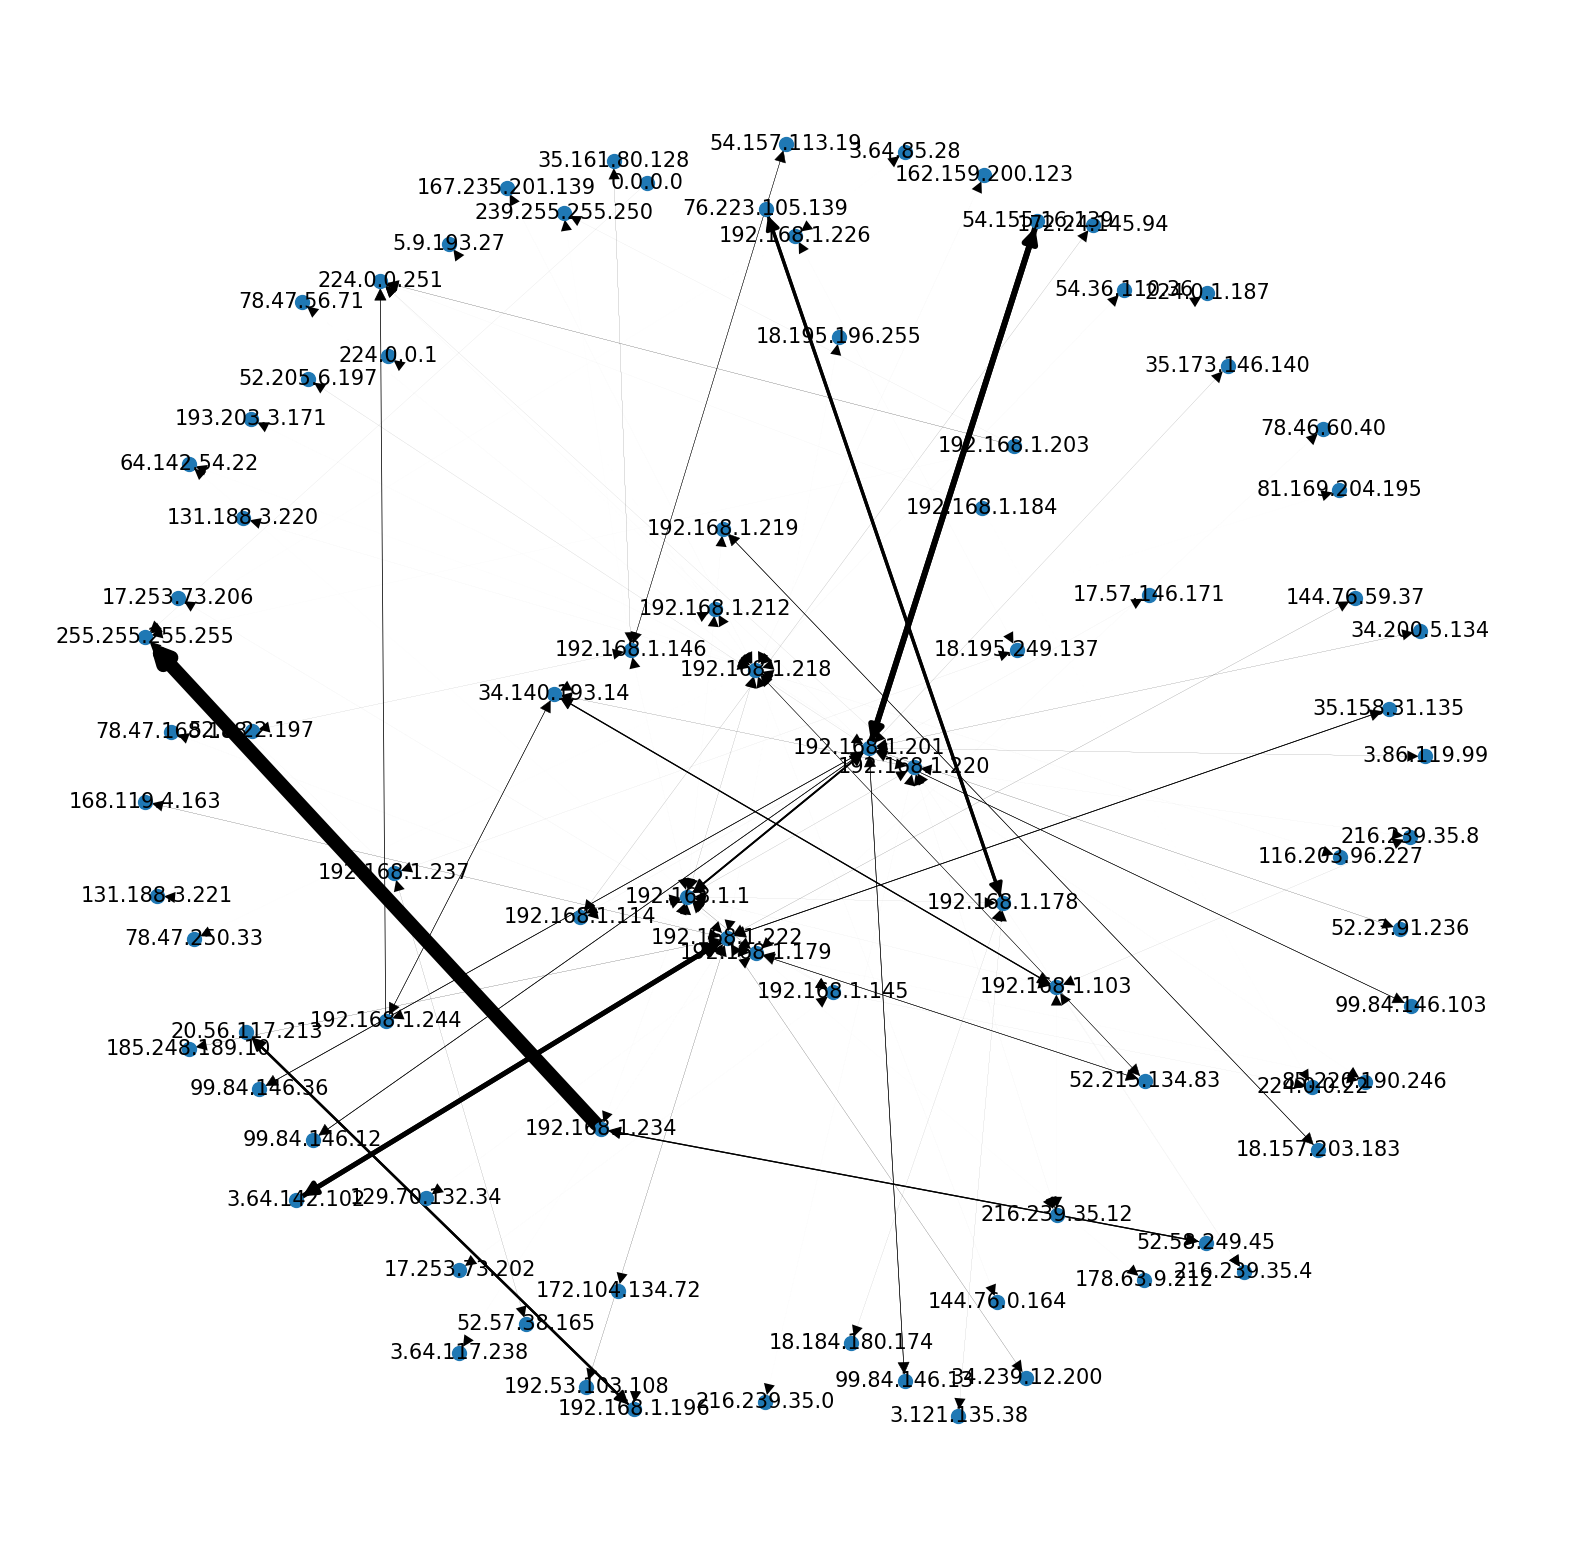

In [12]:
fig = plt.figure(figsize=(20, 20))
# draw graph, with labels, node size, font size, width, arrowsize, arrowstyle, edge color, layout, axis
# set linewidth to the number of packets per second
edge_weigths = [sum(layer_3_graph[u][v]["packets_per_second"]) for u, v in layer_3_graph.edges()]
max = np.max(edge_weigths)
edge_weigths = [w / max * 10 for w in edge_weigths]

pos = nx.spring_layout(layer_3_graph, k=1, iterations=50)
nx.draw(layer_3_graph, pos, with_labels=True, width=edge_weigths,
        node_size=100, font_size=15, arrowsize=20, arrowstyle='-|>',
        ax=fig.add_subplot(111), edge_cmap=plt.cm.Blues)

# nx.draw(layer_3_graph, with_labels=True, node_size=100, font_size=15,
#         width=2, arrowsize=20, arrowstyle='-|>',
#         pos=nx.spring_layout(layer_3_graph, k=1, iterations=50),
#         ax=fig.add_subplot(111), edge_weigths=edge_weigths, edge_cmap=plt.cm.Blues)

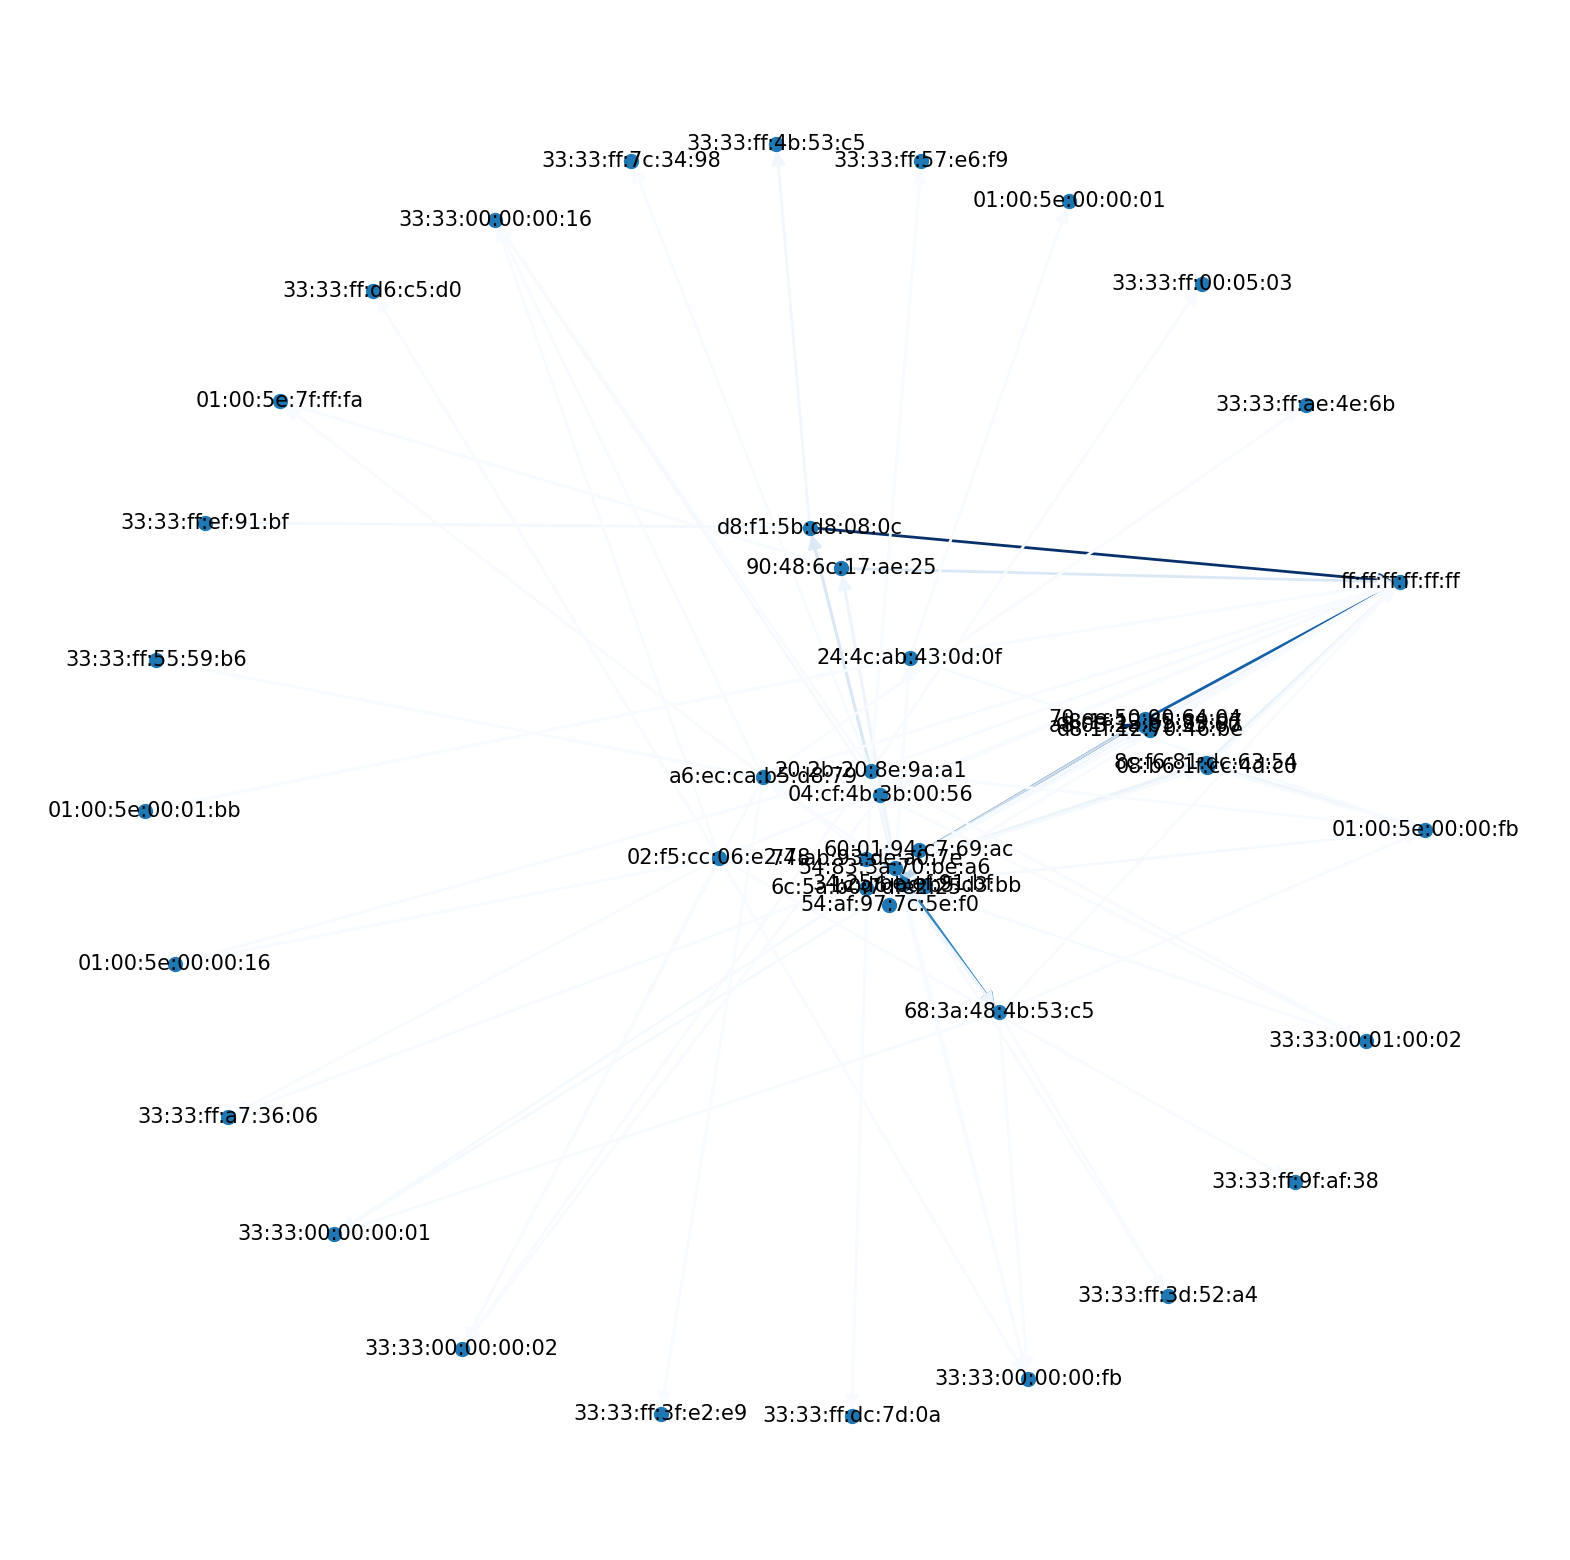

In [13]:
fig = plt.figure(figsize=(20, 20))
edge_weigths = [sum(layer_2_graph[u][v]["packets_per_second"]) for u, v in layer_2_graph.edges()]

nx.draw(layer_2_graph, with_labels=True, node_size=100, font_size=15,
        width=2, arrowsize=20, arrowstyle='-|>',
        pos=nx.spring_layout(layer_2_graph, k=0.8, iterations=500),
        ax=fig.add_subplot(111), edge_color=edge_weigths, edge_cmap=plt.cm.Blues)

In [14]:
# get all edge labels for layer 2 graph
edge_labels = nx.get_edge_attributes(layer_2_graph, 'bytes_per_second')

edge_labels

{('54:83:3a:70:be:a6', '68:3a:48:4b:53:c5'): {0: 66,
  2: 218,
  3: 164,
  8: 357,
  20: 66,
  25: 42,
  33: 105,
  40: 66,
  47: 314,
  48: 6829,
  61: 66,
  64: 105,
  66: 42,
  73: 357,
  81: 66,
  95: 105,
  102: 66,
  107: 356,
  108: 6829,
  122: 66,
  127: 105,
  137: 304,
  142: 164,
  143: 66,
  147: 164,
  148: 42,
  158: 105,
  163: 66,
  168: 7096,
  169: 132,
  184: 66,
  189: 147,
  204: 66,
  220: 105,
  225: 66,
  228: 314,
  229: 6829,
  230: 42,
  244: 113,
  245: 66,
  255: 2898,
  256: 527,
  266: 66,
  271: 42,
  275: 105,
  281: 304,
  286: 230,
  288: 314,
  289: 6829,
  291: 164,
  306: 105,
  307: 66,
  311: 42,
  327: 66,
  337: 105,
  348: 380,
  349: 6829,
  353: 42,
  368: 105,
  369: 171,
  370: 105,
  371: 210,
  391: 66,
  396: 42,
  403: 105,
  408: 314,
  409: 6829,
  411: 66,
  425: 304,
  430: 206,
  432: 66,
  434: 105,
  435: 164,
  452: 66,
  465: 105,
  468: 314,
  469: 6829,
  470: 42,
  473: 66,
  485: 113,
  493: 66,
  514: 66,
  516: 105,
  5

In [15]:
# get size of state in bytes
import sys


def get_total_size(obj, seen=None):
    """Recursively finds size of objects in bytes"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    seen.add(obj_id)

    if isinstance(obj, dict):
        size += sum([get_total_size(v, seen) + get_total_size(k, seen) for k, v in obj.items()])
    elif hasattr(obj, '__dict__'):
        size += get_total_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_total_size(i, seen) for i in obj])

    return size


get_total_size(state) / 1000 / 1000

9.288388000000001